In [55]:
import os
import sys
import re
import json
import time
import spacy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import praw

import google.generativeai as genai # Google Gemini API

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from datetime import datetime
from openai import OpenAI # OpenAI API
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation # LDA Topic Modeling

import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

from tqdm.auto import tqdm

In [56]:
df = pd.read_excel('./reddit_reviews_suggest.xlsx')

In [57]:
# 테스트 NLP Preprocessing

# Spacy 모델 로드 (품사 태깅 및 표제어 추출용)
# 설치 필요: python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])

# 1. 기술 속성 구조화 함수 (기존 로직 유지)
def disambiguate_specs(text):
    text = text.lower()
    # 가격, 프레임, 해상도, 전력 등 수치 데이터의 의미론적 통합
    text = re.sub(r'\$(\d+)', r'price_\1', text)
    text = re.sub(r'\b(\d+)\s?(dollars|usd|bucks)\b', r'price_\1', text)
    text = re.sub(r'\b(\d{2,3})\s?(fps|hz)\b', r'fps_\1', text)
    text = re.sub(r'\b(\d{3,4})[pP]\b', r'res_\1p', text)
    text = re.sub(r'\b4[kK]\b', r'res_4k', text)
    text = re.sub(r'\b(\d+)\s?w\b', r'power_\1w', text)
    return text

# 2. 행위 중심(Activity-centric) 텍스트 정제 함수
def purpose_driven_clean(text):
    if not isinstance(text, str): return ""
    
    # A. 기본 노이즈 제거 및 스펙 단위 변환
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = text.replace('\n', ' ')
    text = disambiguate_specs(text)
    text = re.sub(r'[^a-z0-9_]', ' ', text) # 언더바(_) 보존
    
    # B. SpaCy를 이용한 정밀 분석
    doc = nlp(text)
    tokens = []
    
    # 목적 도출에 핵심적인 품사들만 선택 (명사, 동사, 형용사)
    # VERB를 포함함으로써 'playing', 'editing', 'working' 등 행위 정보를 포착
    allowed_postags = ['NOUN', 'VERB', 'ADJ']
    
    # 연구에서 '목적'을 정의하기 위해 반드시 살아있어야 하는 단어들 (기존 삭제 항목에서 제외)
    # 'game', 'play' 등이 살아있어야 'Gaming' 목적 군집이 형성됩니다.
    keep_for_purpose = {'game', 'play', 'use', 'work', 'study', 'edit', 'code', 'run'}
    
    for token in doc:
        # 불용어(Stopwords)이더라도 목적 관련 핵심어라면 통과
        is_purpose_keyword = token.text in keep_for_purpose
        
        if (is_purpose_keyword) or (not token.is_stop and token.pos_ in allowed_postags):
            # 표제어 추출 (Lemmatization)
            lemma = token.lemma_
            
            # 너무 짧은 단어 필터링 (숫자나 구조화된 스펙 제외)
            if len(lemma) > 2 or lemma.isdigit() or "_" in lemma:
                tokens.append(lemma)
    
    return " ".join(tokens)

# 3. 데이터프레임 적용 파이프라인
def preprocess_for_purpose_discovery(df):
    print("전처리 시작: 사용 목적(Purpose) 신호 강화 모드")
    
    # 원문이 삭제된 경우 제외
    df = df[~df['Body'].isin(['[deleted]', '[removed]'])].copy()
    
    # 전처리 적용 (tqdm으로 진행률 표시)
    tqdm.pandas()
    df['cleaned_Body'] = df['Body'].progress_apply(purpose_driven_clean)
    
    # 단어 수 기반 필터링 (정보량이 너무 적은 리뷰 제외)
    df['word_count'] = df['cleaned_Body'].apply(lambda x: len(str(x).split()))
    df = df[df['word_count'] >= 5] 
    
    print(f"전처리 완료. 최종 데이터 수: {len(df)}")
    return df

# 실행 예시
# _df_valid = preprocess_for_purpose_discovery(_df_raw)

In [58]:
df = preprocess_for_purpose_discovery(df)

전처리 시작: 사용 목적(Purpose) 신호 강화 모드


100%|██████████| 659/659 [00:03<00:00, 181.58it/s]

전처리 완료. 최종 데이터 수: 504


In [3]:
# df_tagged = pd.read_excel('reddit_reviews_tagged_openai_v2.xlsx')

df = pd.read_excel('reddit_reviews_cleaned.xlsx')

In [4]:
df.head()

,Unnamed: 0,Type,Body,Date,URL,cleaned_Body,word_count
0,2,Comment,Any recommendations for laptops mainly for onl...,2022-03-17 10:25:31,https://www.reddit.com/r/laptops/comments/7eon...,recommendation laptop mainly online college co...,9
1,3,Comment,I found a lenovo gaming laptop with a 3060 GPU...,2022-09-11 17:39:45,https://www.reddit.com/r/laptops/comments/7eon...,find lenovo game laptop 3060 gpu amd ryzen 5 5...,22
2,4,Comment,Alright I have narrowed it down to TWO laptops...,2023-03-16 00:32:41,https://www.reddit.com/r/laptops/comments/7eon...,alright narrow laptop finally haha travel year...,43
3,5,Comment,I had an option to buy 3050 ti with 17 11thgen...,2023-05-26 22:06:12,https://www.reddit.com/r/laptops/comments/7eon...,option buy 3050 17 11thgen buy 3060 ryzen 5600...,11
4,6,Comment,I’m looking for a laptop in the $500-$700 rang...,2024-04-09 12:00:30,https://www.reddit.com/r/laptops/comments/7eon...,look laptop price_500 price_700 range work wri...,21


### Topic Modeling - LDA

In [59]:
# Topic Modeling using LDA

print(f"Valid 전처리 이전 데이터 개수 : {df.shape[0]}")

_df = df.copy()

_df_valid = _df.dropna(subset = ['cleaned_Body']) # 결측치 제거
_df_valid = _df_valid[_df_valid['cleaned_Body'].str.strip().astype(bool)] # 빈 문자열 제거

print(f"Valid 전처리 이후 데이터 개수 : {_df_valid.shape[0]}")

Valid 전처리 이전 데이터 개수 : 504
Valid 전처리 이후 데이터 개수 : 504


In [ ]:
# Topic Modeling using LDA

# _df = df_tagged.copy()

# _df_valid = _df[_df['is_valid'] == True]

# print(f"Valid 데이터 개수: {_df_valid.shape[0]}")
# _df_valid = _df_valid.dropna(subset=['cleaned_Body']) # 결측치 제거
# _df_valid = _df_valid[_df_valid['cleaned_Body'].str.strip().astype(bool)] # 빈 문자열 제거
# print(f"전처리 후 Valid 데이터 개수: {_df_valid.shape[0]}")

Valid 데이터 개수: 302
전처리 후 Valid 데이터 개수: 302


In [61]:
# Perplexity (purpose 획득을 위한 Topic Modeling)

def compute_perplexity(df, vectorizer):
    perplexity_values = []
    k_range = range(2, 11)
    for k in k_range:
        dtm = vectorizer.fit_transform(df['cleaned_Body'])
        feature_names = vectorizer.get_feature_names_out()
        lda = LatentDirichletAllocation(
            n_components = k,
            random_state = 42,
            max_iter = 10,
            learning_method = 'online',
            n_jobs = -1,
        )
        lda.fit(dtm)
        perp_val = lda.perplexity(dtm)
        perplexity_values.append((k, perp_val))
    return perplexity_values

# Coherence (purpose 획득을 위한 Topic Modeling)

def compute_coherence(df, vectorizer):
    coherence_values = []
    k_range = range(2, 11)
    for k in k_range:
        dtm = vectorizer.fit_transform(df['cleaned_Body'])
        feature_names = vectorizer.get_feature_names_out()
        lda = LatentDirichletAllocation(
            n_components = k,
            random_state = 42,
            max_iter = 10,
            learning_method = 'online',
            n_jobs = -1,
        )
        lda.fit(dtm)
        
        topics = lda.components_
        top_n = 10
        coherence_sum = 0

        for topic in topics:
            top_indices = topic.argsort()[-top_n:][::-1]
            for i in range(len(top_indices) - 1):
                for j in range(i+1, len(top_indices)):
                    word_i = top_indices[i]
                    word_j = top_indices[j]
                    co_occur = (dtm[:, word_i].toarray() > 0) & (dtm[:, word_j].toarray() > 0)
                    co_occur_count = co_occur.sum()
                    word_j_count = (dtm[:, word_j].toarray() > 0).sum()
                    if word_j_count > 0:
                        coherence_sum += np.log((co_occur_count + 1) / word_j_count)
        coherence_values.append((k, coherence_sum / k))
    return coherence_values

In [6]:
# Perplexity

def compute_perplexity(df, vectorizer):
    keys = df['key_priority'].unique()
    perplexity_values = []
    k_range = range(2, 11)
    for key in keys:
        print(f"Processing key_priority: {key}")
        dtm = vectorizer.fit_transform(df[df['key_priority'] == key]['cleaned_Body'])
        feature_names = vectorizer.get_feature_names_out()
        for k in k_range:
            lda = LatentDirichletAllocation(
                n_components = k,
                random_state = 42,
                max_iter = 10,
                learning_method = 'online',
                n_jobs = -1,
            )
            lda.fit(dtm)

            perp_val = lda.perplexity(dtm)
            perplexity_values.append((key, k, perp_val))
    # 시각화
    perplexity_df = pd.DataFrame(perplexity_values, columns = ['key_priority', 'n_topics', 'perplexity'])
    sns.lineplot(data = perplexity_df, x = 'n_topics', y = 'perplexity', hue = 'key_priority')
    plt.title('LDA Perplexity by Number of Topics and Key Priority')
    plt.xlabel('Number of Topics (K)')
    plt.ylabel('Perplexity')
    plt.legend(title = 'Key Priority')
    plt.show()

# Coherence
def compute_coherence(df, vectorizer):
    keys = df['key_priority'].unique()
    coherence_values = []
    k_range = range(2, 11)
    
    for key in keys:
        print(f"Processing key_priority: {key}")
        dtm = vectorizer.fit_transform(df[df['key_priority'] == key]['cleaned_Body'])
        feature_names = vectorizer.get_feature_names_out()
        
        for k in k_range:
            lda = LatentDirichletAllocation(
                n_components=k,
                random_state=42,
                max_iter=10,
                learning_method='online',
                n_jobs=-1,
            )
            lda.fit(dtm)
            
            # UMass Coherence 계산 (sklearn 기반)
            topics = lda.components_
            top_n = 10
            coherence_sum = 0
            
            for topic in topics:
                top_indices = topic.argsort()[-top_n:][::-1]
                # 상위 단어들 간의 동시 출현 기반 coherence
                for i in range(len(top_indices)-1):
                    for j in range(i+1, len(top_indices)):
                        word_i = top_indices[i]
                        word_j = top_indices[j]
                        # 두 단어가 함께 나타나는 문서 수
                        co_occur = (dtm[:, word_i].toarray() > 0) & (dtm[:, word_j].toarray() > 0)
                        co_occur_count = co_occur.sum()
                        word_j_count = (dtm[:, word_j].toarray() > 0).sum()
                        if word_j_count > 0:
                            coherence_sum += np.log((co_occur_count + 1) / word_j_count)
            
            coherence_values.append((key, k, coherence_sum / k))
    
    # 시각화
    coherence_df = pd.DataFrame(coherence_values, columns=['key_priority', 'n_topics', 'coherence'])
    sns.lineplot(data=coherence_df, x='n_topics', y='coherence', hue='key_priority')
    plt.title('LDA Coherence by Number of Topics and Key Priority')
    plt.xlabel('Number of Topics (K)')
    plt.ylabel('Coherence')
    plt.legend(title='Key Priority')
    plt.show()

In [62]:
# 정의

vectorizer = CountVectorizer(
    stop_words = 'english',
    max_features = 1000,
    ngram_range = (1, 2),
    max_df = 0.9,
    min_df = 2,
) # 기본 구성

In [63]:
# 지표 계산

perplexity = compute_perplexity(_df_valid, vectorizer)
coherence = compute_coherence(_df_valid, vectorizer)
perplexity_df = pd.DataFrame(perplexity, columns = ['n_topics', 'perplexity'])
coherence_df = pd.DataFrame(coherence, columns = ['n_topics', 'coherence'])

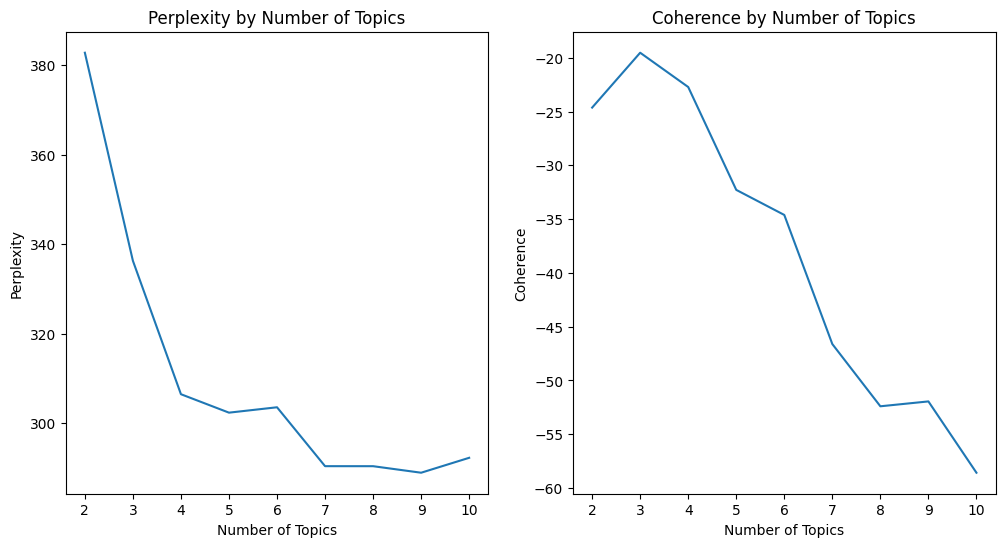

In [64]:
# 시각화
fig, ax = plt.subplots(1,2, figsize = (12, 6))

sns.lineplot(data = perplexity_df, x = 'n_topics', y = 'perplexity', ax = ax[0])
ax[0].set_title('Perplexity by Number of Topics')
ax[0].set_xlabel('Number of Topics')
ax[0].set_ylabel('Perplexity')

sns.lineplot(data = coherence_df, x = 'n_topics', y = 'coherence', ax = ax[1])
ax[1].set_title('Coherence by Number of Topics')
ax[1].set_xlabel('Number of Topics')
ax[1].set_ylabel('Coherence')
plt.show()

Processing key_priority: Visuals
Processing key_priority: Portability
Processing key_priority: Performance
Processing key_priority: Battery
Processing key_priority: Comfort
Processing key_priority: Price


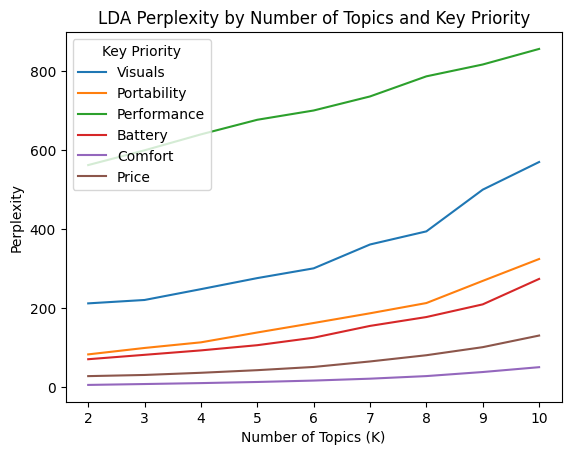

In [ ]:
# Perplexity와 토픽 수의 관계 시각화

# compute_perplexity(_df_valid, vectorizer)

Processing key_priority: Visuals
Processing key_priority: Portability
Processing key_priority: Performance
Processing key_priority: Battery
Processing key_priority: Comfort
Processing key_priority: Price


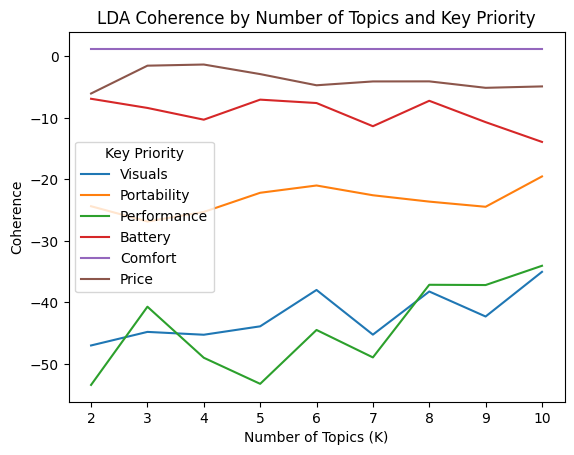

In [ ]:
# Coherence와 토픽 수의 관계 시각화

# compute_coherence(_df_valid, vectorizer)

In [65]:
# Topic Modeling (K = 5)

K = 4 # 토픽 개수

_df = _df_valid.reset_index(drop = True).copy()
dtm = vectorizer.fit_transform(_df['cleaned_Body'])
feature_names = vectorizer.get_feature_names_out()

lda = LatentDirichletAllocation(
    n_components = K,
    random_state = 42,
    max_iter = 10,
    learning_method = 'online',
    n_jobs = -1,
)
lda.fit(dtm) # 학습

,"n_components n_components: int, default=10Number of topics... versionchanged:: 0.19 ``n_topics`` was renamed to ``n_components``",4
,"doc_topic_prior doc_topic_prior: float, default=NonePrior of document topic distribution `theta`. If the value is None,defaults to `1 / n_components`.In [1]_, this is called `alpha`.",None
,"topic_word_prior topic_word_prior: float, default=NonePrior of topic word distribution `beta`. If the value is None, defaultsto `1 / n_components`.In [1]_, this is called `eta`.",None
,"learning_method learning_method: {'batch', 'online'}, default='batch'Method used to update `_component`. Only used in :meth:`fit` method.In general, if the data size is large, the online update will be muchfaster than the batch update.Valid options:- 'batch': Batch variational Bayes method. Use all training data in each EM update. Old `components_` will be overwritten in each iteration.- 'online': Online variational Bayes method. In each EM update, use mini-batch of training data to update the ``components_`` variable incrementally. The learning rate is controlled by the ``learning_decay`` and the ``learning_offset`` parameters... versionchanged:: 0.20 The default learning method is now ``""batch""``.",'online'
,"learning_decay learning_decay: float, default=0.7It is a parameter that control learning rate in the online learningmethod. The value should be set between (0.5, 1.0] to guaranteeasymptotic convergence. When the value is 0.0 and batch_size is``n_samples``, the update method is same as batch learning. In theliterature, this is called kappa.",0.7
,"learning_offset learning_offset: float, default=10.0A (positive) parameter that downweights early iterations in onlinelearning. It should be greater than 1.0. In the literature, this iscalled tau_0.",10.0
,"max_iter max_iter: int, default=10The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the :meth:`fit` method, and not the:meth:`partial_fit` method.",10
,"batch_size batch_size: int, default=128Number of documents to use in each EM iteration. Only used in onlinelearning.",128
,"evaluate_every evaluate_every: int, default=-1How often to evaluate perplexity. Only used in `fit` method.set it to 0 or negative number to not evaluate perplexity intraining at all. Evaluating perplexity can help you check convergencein training process, but it will also increase total training time.Evaluating perplexity in every iteration might increase training timeup to two-fold.",-1
,"total_samples total_samples: int, default=1e6Total number of documents. Only used in the :meth:`partial_fit` method.",1000000.0
,"perp_tol perp_tol: float, default=1e-1Perplexity tolerance. Only used when ``evaluate_every`` is greater than 0.",0.1


In [66]:
# 확인

topics = []
for topic_idx, topic in enumerate(lda.components_):
    top_feature_ind = topic.argsort()[-10:][::-1]
    top_features = [feature_names[i] for i in top_feature_ind]
    topics.append(', '.join(top_features))

print(topics)

['ryzen, ram, performance, ultra, game, laptop, igpu, good, cpus, limit', 'pro, laptop, link, battery, life, battery life, use, cpu, ram, screen', 'laptop, ram, good, ssd, new, screen, ryzen, igpu, ultra, review', 'cpu, recommend, link, screen, ram, use, game, high, good, storage']


In [67]:
for idx, topic in enumerate(topics):
    print(f"Topic {idx}: {topic}")

Topic 0: ryzen, ram, performance, ultra, game, laptop, igpu, good, cpus, limit
Topic 1: pro, laptop, link, battery, life, battery life, use, cpu, ram, screen
Topic 2: laptop, ram, good, ssd, new, screen, ryzen, igpu, ultra, review
Topic 3: cpu, recommend, link, screen, ram, use, game, high, good, storage


In [ ]:
# 주제별 토픽 모델링

# k_dict = {
#     'Price' : 3,
#     'Battery' : 5,
#     'Portability' : 6,
#     'Visuals' : 6,
#     'Performance' : 3
# }

# lda_topic_modeling_results = {}

# for key, k in k_dict.items():
#     print(f"Processing key_priority: {key} with {k} topics")
#     dtm = vectorizer.fit_transform(_df_valid[_df_valid['key_priority'] == key]['cleaned_Body'])
#     lda = LatentDirichletAllocation(
#         n_components = k,
#         random_state = 42,
#         max_iter = 10,
#         learning_method = 'online',
#         n_jobs = -1,
#     )
#     lda.fit(dtm)
#     lda_topic_modeling_results[key] = lda

Processing key_priority: Price with 3 topics
Processing key_priority: Battery with 5 topics
Processing key_priority: Portability with 6 topics
Processing key_priority: Visuals with 6 topics
Processing key_priority: Performance with 3 topics


In [ ]:
# 주제별 토픽 모델링

k_dict = {
    'Price' : 3,
    'Battery' : 5,
    'Portability' : 6,
    'Visuals' : 6,
    'Performance' : 3
}

# 결과를 저장할 딕셔너리 (나중에 엑셀로 뽑기 위함)
lda_final_results = {}

for key, k in k_dict.items():
    print(f"Processing key_priority: {key} with {k} topics")
    
    # 1. 데이터 필터링 및 인덱스 초기화 (중요!)
    # 인덱스를 리셋해야 나중에 LDA 결과(행 번호)와 데이터프레임(행 번호)을 매칭할 수 있습니다.
    subset_df = _df_valid[_df_valid['key_priority'] == key].reset_index(drop=True)
    
    # 2. 벡터화 (해당 카테고리 데이터에 맞게 단어장 생성)
    # vectorizer는 루프 밖에서 미리 정의되어 있어야 합니다 (예: CountVectorizer)
    dtm = vectorizer.fit_transform(subset_df['cleaned_Body'])
    feature_names = vectorizer.get_feature_names_out()
    
    # 3. LDA 모델 학습
    lda = LatentDirichletAllocation(
        n_components = k,
        random_state = 42,
        max_iter = 10,
        learning_method = 'online',
        n_jobs = -1,
    )
    lda.fit(dtm)
    
    # 4. [핵심] 문서별 토픽 기여도 계산 (Transform)
    # doc_topic_dist: (문서 수 x 토픽 수) 크기의 행렬
    # 예: [[0.1, 0.9, ...], [0.8, 0.2, ...]]
    doc_topic_dist = lda.transform(dtm)
    
    # 5. 토픽별 정보 추출 (키워드 + 대표 문서)
    topic_summary_list = []
    
    for topic_idx, topic in enumerate(lda.components_):
        # A. 상위 키워드 추출 (기존 로직)
        top_features_indices = topic.argsort()[-10:][::-1]
        top_features = [feature_names[i] for i in top_features_indices]
        keywords_str = ", ".join(top_features)
        
        # B. 대표 문서 추출 (신규 로직)
        # 현재 토픽(topic_idx)에 대한 모든 문서의 기여도(확률) 가져오기
        topic_col_probs = doc_topic_dist[:, topic_idx]
        
        # 기여도가 가장 높은 상위 3개 문서의 인덱스 찾기
        top_doc_indices = topic_col_probs.argsort()[-3:][::-1]
        
        # 인덱스로 원본 데이터에서 'Body' 가져오기
        # (전처리된 텍스트 말고 읽기 좋은 원본 'Body'를 가져옵니다)
        rep_docs = subset_df.loc[top_doc_indices, 'Body'].tolist()
        
        # 보기 좋게 구분자로 합치기
        rep_docs_str = "\n--------------------\n".join(rep_docs)
        
        # 결과 리스트에 추가
        topic_summary_list.append({
            "Category": key,
            "Topic": topic_idx + 1,
            "Top_Keywords": keywords_str,
            "Representative_Docs": rep_docs_str
        })
    
    # 6. 해당 카테고리의 결과를 DataFrame으로 변환 및 저장
    results_df = pd.DataFrame(topic_summary_list)
    lda_final_results[key] = results_df
    
    # (선택) CSV 파일로 바로 저장
    filename = fs"LDA_Result_with_Docs_{key}.csv"
    results_df.to_csv(filename, index=False, encoding='utf-8-sig')
    print(f"  Saved: {filename}")

print("\n모든 분석 완료!")

Processing key_priority: Price with 3 topics
  Saved: LDA_Result_with_Docs_Price.csv
Processing key_priority: Battery with 5 topics
  Saved: LDA_Result_with_Docs_Battery.csv
Processing key_priority: Portability with 6 topics
  Saved: LDA_Result_with_Docs_Portability.csv
Processing key_priority: Visuals with 6 topics
  Saved: LDA_Result_with_Docs_Visuals.csv
Processing key_priority: Performance with 3 topics
  Saved: LDA_Result_with_Docs_Performance.csv

모든 분석 완료!


In [ ]:
# 확인

# for key in lda_topic_modeling_results.keys():
#     print(f"Top words for key_priority: {key}")
#     lda = lda_topic_modeling_results[key]
#     feature_names = vectorizer.get_feature_names_out()
#     for topic_idx, topic in enumerate(lda.components_):
#         top_features_indices = topic.argsort()[-10:][::-1]
#         top_features = [feature_names[i] for i in top_features_indices]
#         print(f"  Topic {topic_idx + 1}: {', '.join(top_features)}")
#     print("\n")

Top words for key_priority: Price
  Topic 1: 15, 3070, 10, 2025, 20, 1080p30 handheld, 300, 2077, 450, 3rd party
  Topic 2: 3rd, 30, 3rd party, 700, 15, 2020, 400, 10, 360, 30 40
  Topic 3: 30, 2077, 1080p30, 20, 2025, 40, 1080p30 handheld, 3070, 360, 450


Top words for key_priority: Battery
  Topic 1: 720p30fps, acceptable framerate, 3070, 720, 20, 2077, 8core, 3rd party, ally, 400
  Topic 2: area, acceptable, aaa, ago, ally, 3rd party, 450, able run, actually, 700
  Topic 3: ampere, 720p30, 720p30 steam, 20, 700, 3rd, 8core, actually power, 2077, area
  Topic 4: 750ti, adult, 3rd, 720p30 steam, able run, 720p30fps, absolutely, anymore, 30 40, advanced
  Topic 5: ampere, 2020, 700, able, 8core, accept, ahead steam, 30, 360, alot steam


Top words for key_priority: Portability
  Topic 1: balanced, agree, able, 2025, 20, 3rd party, 40, aren, basic, arm
  Topic 2: balanced, area, aren, 720p30fps, arm, 3rd, 3070, 2025, 20, available
  Topic 3: balanced, 30 40, 700, amazing, advantage, ba

### Topic Modeling - BERTopic

In [74]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN

In [78]:
df = pd.read_excel('./reddit_reviews_suggest.xlsx')

In [79]:
_df = df.copy()

In [76]:
# Topic Modeling using BERTopic

# _df = df_tagged.copy()
_df = df.copy()

print(f"데이터 개수: {_df.shape[0]}")
_df = _df.dropna(subset=['cleaned_Body']) # 결측치 제거
_df = _df[_df['cleaned_Body'].str.strip().astype(bool)] # 빈 문자열 제거
print(f"전처리 후 데이터 개수: {_df.shape[0]}")

데이터 개수: 659


KeyError: ['cleaned_Body']

In [ ]:
# # 1. 데이터 준비 (Performance와 Visuals만 필터링)
# # 데이터가 많은 카테고리 위주로 먼저 돌려보는 전략입니다.
# target_categories = ['Performance', 'Visuals']
# subset_df = _df_valid[_df_valid['key_priority'].isin(target_categories)].copy()

# # 앞서 만든 전처리된 컬럼('cleaned_Body')을 사용하는 것을 강력 추천합니다.
# # (숫자 단위가 fps_60 등으로 변환된 상태여야 분석이 명확합니다)
# docs = subset_df['cleaned_Body'].tolist()
# timestamps = subset_df['Date'].tolist() # (선택사항) 나중에 시계열 분석을 위해

# print(f"분석 대상 문서 개수: {len(docs)}")

# # 2. 하이퍼파라미터 설정 (연구용 튜닝)

# # A. 임베딩 차원 축소 (UMAP)
# # random_state를 고정해야 매번 실행할 때마다 결과가 달라지지 않습니다.
# umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# # B. 클러스터링 (HDBSCAN)
# # min_cluster_size: 이 숫자보다 작은 토픽은 만들지 않음 (노이즈로 처리)
# # 데이터가 많으므로 15~20 정도로 설정하여 자잘한 토픽 생성을 방지합니다.
# hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# # C. 토픽 표현 (CountVectorizer)
# # 불용어 처리를 여기서 한 번 더 확실하게 해줍니다.
# # n_gram_range=(1, 2): "steam deck", "frame rate" 같은 두 단어 조합도 잡습니다.
# vectorizer_model = CountVectorizer(
#     stop_words = 'english',
#     max_features = 1000,
#     ngram_range = (1, 2),
#     max_df = 0.9,
#     min_df = 2,
# ) # 기본 구성

# # 3. 모델 생성 및 학습
# topic_model = BERTopic(
#     embedding_model="all-MiniLM-L6-v2", # 영어 문맥 파악에 가볍고 성능 좋은 표준 모델
#     umap_model=umap_model,
#     hdbscan_model=hdbscan_model,
#     vectorizer_model=vectorizer_model,
#     calculate_probabilities=True,
#     verbose=True
# )

# # 학습 시작 (시간이 좀 걸릴 수 있습니다)
# print("BERTopic 학습 중...")
# topics, probs = topic_model.fit_transform(docs)

# # 4. 결과 확인
# print("\n=== 토픽 정보 ===")
# # 전체 토픽 리스트 출력 (상위 10개)
# print(topic_model.get_topic_info().head(10))

# # 5. 개별 토픽의 키워드 확인 (예: 0번 토픽)
# print("\n=== Topic 0의 주요 키워드 ===")
# print(topic_model.get_topic(0))

분석 대상 문서 개수: 254
BERTopic 학습 중...


2026-01-21 00:36:05,820 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 8/8 [00:04<00:00,  1.75it/s]
2026-01-21 00:36:28,601 - BERTopic - Embedding - Completed ✓
2026-01-21 00:36:28,603 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2026-01-21 00:36:35,428 - BERTopic - Dimensionality - Completed ✓
2026-01-21 00:36:35,429 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-21 00:36:35,459 - BERTopic - Cluster - Completed ✓
2026-01-21 00:36:35,471 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-21 00:36:35,489 - BERTopic - Representation - Completed ✓



=== 토픽 정보 ===
   Topic  Count                                       Name  \
0     -1     97              -1_good_game_fps_120_nintendo   
1      0     90             0_game_nintendo_hardware_price   
2      1     42  1_1080p30_switch run_fsr_1080p30 handheld   
3      2     25        2_res_540p_res_1080p 30_res_360p_40   

                                      Representation  \
0  [good, game, fps_120, nintendo, fps_60, wii, d...   
1  [game, nintendo, hardware, price, ps5, people,...   
2  [1080p30, switch run, fsr, 1080p30 handheld, d...   
3  [res_540p, res_1080p 30, res_360p, 40, perform...   

                                 Representative_Docs  
0  [gamer play nintendo exclusive year emulation ...  
1  [people expect switch 2 run fps_60 res_1080p h...  
2  [well switch 2 run 720p30 deck 1080p30 switch ...  
3  [native res_1080p 30 handheld quality mode res...  

=== Topic 0의 주요 키워드 ===
[('game', np.float64(0.08524959229245031)), ('nintendo', np.float64(0.07117805336053439)), ('

In [81]:
# Topic Modeling using BERTopic

# docs = _df['cleaned_Body'].tolist()
docs = df['Body'].tolist()

# 모델 설정
umap_model = UMAP(n_neighbors = 50, n_components = 10, min_dist = 0.0, metric = 'cosine', random_state = 210)
hdbscan_model = HDBSCAN(min_cluster_size = 10, metric = 'euclidean', cluster_selection_method = 'eom', prediction_data = True)
vectorizer_model = CountVectorizer(
    stop_words = 'english',
    max_features = 1000,
    ngram_range = (1, 2),
    max_df = 0.9,
    min_df = 2
)

# 모델 학습
topic_model = BERTopic(
    embedding_model = "all-MiniLM-L6-v2",
    umap_model = umap_model,
    hdbscan_model = hdbscan_model,
    vectorizer_model = vectorizer_model,
    calculate_probabilities = False,
    verbose = True
)

topics, probs = topic_model.fit_transform(docs)

2026-02-03 17:49:15,229 - BERTopic - Embedding - Transforming documents to embeddings.
Loading weights: 100%|██████████| 103/103 [00:00<00:00, 1231.10it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 21/21 [00:09<00:00,  2.22it/s]
2026-02-03 17:49:27,809 - BERTopic - Embedding - Completed ✓
2026-02-03 17:49:27,809 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-02-03 17:49:29,720 - BERTopic - Dimensionality - Completed ✓
2026-02-03 17:49:29,720 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-02-03 17:49:29,741 - BERTopic - Cluster - Completed ✓
2026-02-03 17:49:29,741 - 

In [82]:
# 결과 추출

topic_data = []
info_df = topic_model.get_topic_info()

# 노이즈(-1) 제거
info_df = info_df[info_df['Topic'] != -1]

for index, row in info_df.iterrows():
    topic_id = row['Topic']
    
    keywords = topic_model.get_topic(topic_id)
    keyword_lst = [word for word, score in keywords][:10]
    keywords_str = ", ".join(keyword_lst)

    rep_docs = topic_model.get_representative_docs(topic_id)
    rep_docs_str = "\n--------------------\n".join(rep_docs)

    topic_data.append({
        "Topic": topic_id,
        "Count": row['Count'],
        "Top_Keywords": keywords_str,
        "Representative_Docs": rep_docs_str
    })

final_df = pd.DataFrame(topic_data)

In [83]:
final_df.to_excel('./BERTopic_results.xlsx', index=False)

In [26]:
# 1. 분석할 타겟 카테고리 설정
target_categories = ['Performance', 'Visuals'] 

print(f"분석 시작: {target_categories}")

for category in target_categories:
    print(f"\n" + "="*40)
    print(f"Processing Category: {category}")
    print("="*40)
    
    # 2. 해당 카테고리 데이터만 필터링
    subset_df = _df_valid[_df_valid['key_priority'] == category].copy()
    docs = subset_df['cleaned_Body'].tolist()
    
    if len(docs) < 20:
        print(f"Skipping {category}: 데이터 부족")
        continue

    # 3. 모델 설정 (데이터 특성에 맞게 튜닝)
    # Performance는 데이터가 많으므로 클러스터 최소 크기를 15, Visuals는 10으로 설정 추천
    min_c_size = 15 if category == 'Performance' else 10
    
    umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=210)
    hdbscan_model = HDBSCAN(min_cluster_size=min_c_size, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
    vectorizer_model = CountVectorizer(
        stop_words = 'english',
        max_features = 1000,
        ngram_range = (1, 2),
        max_df = 0.9,
        min_df = 2,
    ) # 기본 구성

    # 4. 모델 학습
    topic_model = BERTopic(
        embedding_model="all-MiniLM-L6-v2",
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        vectorizer_model=vectorizer_model,
        calculate_probabilities=False,
        verbose=True
    )
    
    topics, probs = topic_model.fit_transform(docs)
    
    # 5. 결과 추출 (대표 문서 포함)
    topic_data = []
    info_df = topic_model.get_topic_info()
    
    # 노이즈(-1) 제거
    info_df = info_df[info_df['Topic'] != -1]
    
    for index, row in info_df.iterrows():
        topic_id = row['Topic']
        
        # A. 상위 키워드 10개
        keywords = topic_model.get_topic(topic_id)
        keyword_list = [word for word, score in keywords][:10]
        keywords_str = ", ".join(keyword_list)
        
        # B. ★ 대표 문서(댓글) 3개 추출 ★
        rep_docs = topic_model.get_representative_docs(topic_id)
        # 엑셀에서 보기 편하게 줄바꿈과 구분선으로 합침
        rep_docs_str = "\n--------------------\n".join(rep_docs)
        
        topic_data.append({
            "Topic": topic_id,
            "Count": row['Count'],
            "Top_Keywords": keywords_str,
            "Representative_Docs": rep_docs_str # 여기에 대표 댓글이 들어감
        })
    
    # 6. 저장
    final_df = pd.DataFrame(topic_data)
    
    # 파일명에 'Docs'를 붙여서 저장
    filename = f"BERTopic_Result_with_Docs_{category}.csv"
    final_df.to_csv(filename, index=False, encoding='utf-8-sig')
    
    print(f"Saved completed: {filename}")
    print(final_df.head(3)) # 미리보기 출력

print("\n모든 분석 및 저장 완료!")

2026-01-21 01:32:31,176 - BERTopic - Embedding - Transforming documents to embeddings.


분석 시작: ['Performance', 'Visuals']

Processing Category: Performance


Batches: 100%|██████████| 6/6 [00:00<00:00, 21.53it/s]
2026-01-21 01:32:34,916 - BERTopic - Embedding - Completed ✓
2026-01-21 01:32:34,916 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-21 01:32:35,141 - BERTopic - Dimensionality - Completed ✓
2026-01-21 01:32:35,142 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-21 01:32:35,147 - BERTopic - Cluster - Completed ✓
2026-01-21 01:32:35,156 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-21 01:32:35,170 - BERTopic - Representation - Completed ✓
2026-01-21 01:32:35,185 - BERTopic - Embedding - Transforming documents to embeddings.


Saved completed: BERTopic_Result_with_Docs_Performance.csv
   Topic  Count                                       Top_Keywords  \
0      0     63  setting, steamdeck, mode, doesn, medium, fsr, ...   
1      1     55  price, thing, know, big, exclusive, party, gre...   

                                 Representative_Docs  
0  doesn video doesn setting intensive map check ...  
1  buy nintendo kid soft spot exclusive smash bro...  

Processing Category: Visuals


Batches: 100%|██████████| 3/3 [00:00<00:00, 10.62it/s]
2026-01-21 01:32:38,675 - BERTopic - Embedding - Completed ✓
2026-01-21 01:32:38,676 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-01-21 01:32:38,753 - BERTopic - Dimensionality - Completed ✓
2026-01-21 01:32:38,754 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-01-21 01:32:38,757 - BERTopic - Cluster - Completed ✓
2026-01-21 01:32:38,759 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-01-21 01:32:38,766 - BERTopic - Representation - Completed ✓


Saved completed: BERTopic_Result_with_Docs_Visuals.csv
   Topic  Count                                       Top_Keywords  \
0      0     38  deck, steam, steam deck, handheld, quality, dl...   
1      1     19  nintendo, screen, handheld, hardware, lcd, dev...   

                                 Representative_Docs  
0  switch 2 handheld run high resolution visual q...  
1  buddy realize vast majority people clue fps_12...  

모든 분석 및 저장 완료!
